**Important: This notebook will only work with fastai-0.7.x. Do not try to run any fastai-1.x code from this path in the repository because it will load fastai-0.7.x**

In [ ]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

# The TrainPhase API

*This notebook was prepared by Sylvain Gugger - many thanks!*

Here we show how to use a new API in the fastai library, that allows you all the flexibility you might want while training your model.

All the examples will run on cifar10, so be sure to change the path to a directory that contains this dataset, with the usual hierarchy (a train and a valid folder, each of them containing ten subdirectories for each class).

In [ ]:
from fastai.conv_learner import *
PATH = Path("../data/cifar10/")

In [ ]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
stats = (np.array([ 0.4914 ,  0.48216,  0.44653]), np.array([ 0.24703,  0.24349,  0.26159]))

This will allow us to grab data for a given image size and batch size.

In [ ]:
def get_data(sz,bs):
    tfms = tfms_from_stats(stats, sz, aug_tfms=[RandomFlip()], pad=sz//8)
    return ImageClassifierData.from_paths(PATH, val_name='test', tfms=tfms, bs=bs)

In [ ]:
size = 32
batch_size = 64

In [ ]:
data = get_data(size,batch_size)

Now let's create a very simple model that we'll train: a neural net with a hidden layer.

In [ ]:
def SimpleNet(layers):
    list_layers=[Flatten()]
    for i in range(len(layers)-1):
        list_layers.append(nn.Linear(layers[i], layers[i + 1]))
        if i < len(layers)-2: list_layers.append(nn.ReLU(inplace=True))
        else: list_layers.append(nn.LogSoftmax(dim=0))
    return nn.Sequential(*list_layers)

In [ ]:
learn = ConvLearner.from_model_data(SimpleNet([32*32*3, 40,10]), data)

Now we can use our learner object to give examples of traning.

With the new API, you don't use a pre-implemented training schedule but you can design your own with object called TrainingPhase. A training phase is just a class that will record all the parameters you want to apply during this part of the training loop, specifically:
- a number of epochs for which these settings will be valid (can be a float)
- an optimizer function (SGD, RMSProp, Adam...)
- a learning rate (or array of lrs) or a range of learning rates (or array of lrs) if you want to change the lr.
- a learning rate decay method (that will explain how you want to change the lr)
- a momentum (which will beta1 if you're using Adam), or a range of momentums if you want to change it
- a momentum decay method (that will explain how you want to change the momentum, if applicable)
- optionally a weight decay (or array of wds)
- optionally a beta parameter (which is the RMSProp alpha or the Adam beta2, if you want another vlaue than default)

By combining those blocks as you wish, you can implement pretty much any method of training you could think of.

# Basic lr decay

Let's begin with something basic and say you want to train with SGD and momentum, with a learning rate of 1e-2 for 1 epoch then 1e-3 for two epochs. We'll just create a list of two phases for this.

In [ ]:
phases = [TrainingPhase(epochs=1, opt_fn=optim.SGD, lr = 1e-2), TrainingPhase(epochs=2, opt_fn=optim.SGD, lr = 1e-3)]

Note that we didn't set the momentum parameter because it will default to 0.9. If you don't want any momentum, you'll have to put it to 0.

Now that we have created this list of phases, we just have to call fit_opt_sched.

In [ ]:
learn.fit_opt_sched(phases)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                                                                              
    0      3.406514   4.553418   0.1387    
    1      3.396738   4.559127   0.1383                                                                                
    2      3.421531   4.541069   0.138                                                                                 


[array([4.54107]), 0.138]

If we want to see what we did, we can use learn.sched.plot_lr()

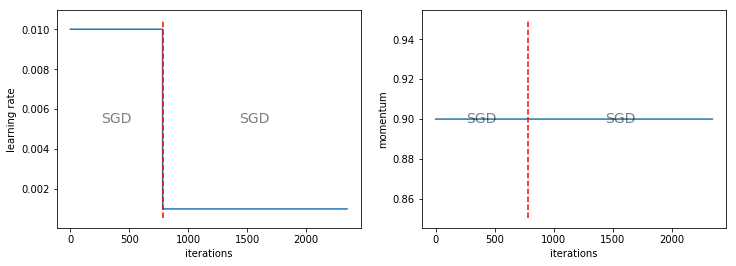

In [ ]:
learn.sched.plot_lr()

The red dashed line represent the change of phase, and the optimizer name (plus its optional parameters) is indicated, in case you changed it. You can remove that off by using show_text=False

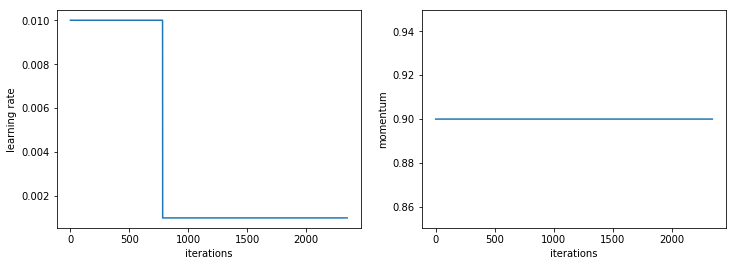

In [ ]:
learn.sched.plot_lr(show_text=False)

Here the momentums don't change at all so we might want to hide them. This is possible with just a simple option.

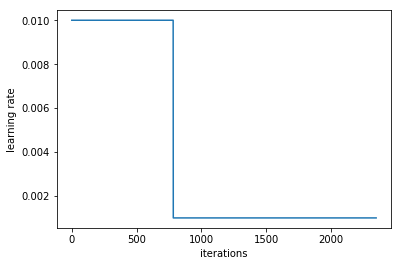

In [ ]:
learn.sched.plot_lr(show_text=False, show_moms=False)

Now let's complicate things a bit more and say we want to train at constant 1e-2 lr for one epoch, then decrease our learning rate to 1e-3 during one epoch and train for one last epoch at 1e-3.

We have currently fours methods of decay (on top of NO that means constant): linear, cosine, exponential or polynomial. Let's have a look at what each of them does.

In [ ]:
phases = [TrainingPhase(epochs=1, opt_fn=optim.SGD, lr = 1e-2), 
          TrainingPhase(epochs=1, opt_fn=optim.SGD, lr = (1e-2,1e-3), lr_decay=DecayType.LINEAR),
          TrainingPhase(epochs=1, opt_fn=optim.SGD, lr = 1e-3)]

In [ ]:
learn.fit_opt_sched(phases)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                                                                              
    0      3.398595   4.563467   0.142     
    1      3.434187   4.567539   0.1435                                                                                
    2      3.402653   4.554236   0.1413                                                                                


[array([4.55424]), 0.1413]

Linear is simply going from a to b with a line. The formula that gives the learning rate at batch i over n is:

In [ ]:
lr_i = start_lr + (end_lr - start_lr) * i/n

(to run the cell above give a value to all the parameters: start_lr, end_lr, i and n)

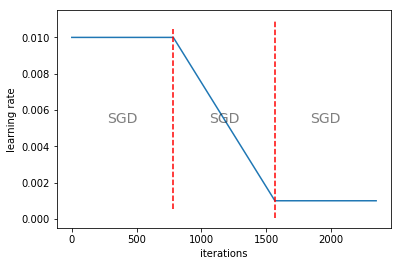

In [ ]:
learn.sched.plot_lr(show_moms=False)

In [ ]:
phases = [TrainingPhase(epochs=1, opt_fn=optim.SGD, lr = 1e-2), 
          TrainingPhase(epochs=1, opt_fn=optim.SGD, lr = (1e-2,1e-3), lr_decay=DecayType.COSINE),
          TrainingPhase(epochs=1, opt_fn=optim.SGD, lr = 1e-3)]

In [ ]:
learn.fit_opt_sched(phases)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                                                                              
    0      3.388045   4.565604   0.1398    
    1      3.406363   4.530048   0.1395                                                                                
    2      3.406011   4.558265   0.1462                                                                                


[array([4.55826]), 0.1462]

Cosine is simply going from a to b with a following half a cosine. The formula that gives the learning rate at batch i over n is:

In [ ]:
lr_i = end_lr + (start_lr - end_lr)/2 * ( 1 +  np.cos( i * np.pi) / n )

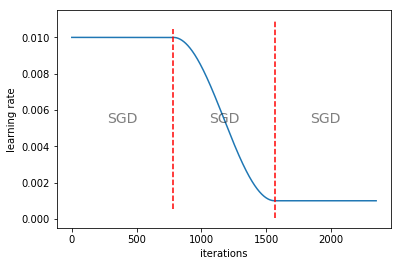

In [ ]:
learn.sched.plot_lr(show_moms=False)

In [ ]:
phases = [TrainingPhase(epochs=1, opt_fn=optim.SGD, lr = 1e-2), 
          TrainingPhase(epochs=1, opt_fn=optim.SGD, lr = (1e-2,1e-3), lr_decay=DecayType.EXPONENTIAL),
          TrainingPhase(epochs=1, opt_fn=optim.SGD, lr = 1e-3)]

In [ ]:
learn.fit_opt_sched(phases)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                                                                              
    0      3.404826   4.560293   0.1391    
    1      3.40894    4.541485   0.1382                                                                                
    2      3.411215   4.539713   0.1385                                                                                


[array([4.53971]), 0.1385]

Exponential is multiplying the learning rate by the same thing at each step, this thing being computed to be exactly what's needed to go from our start point to our end point. Here the learning rate on batch i over n is:

In [ ]:
lr_i = start_lr * (end_lr/start_lr)**(i/n)

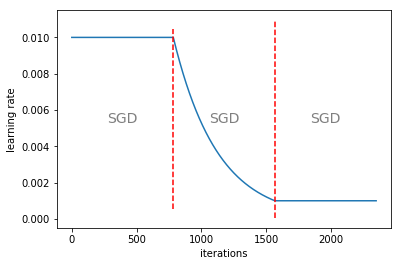

In [ ]:
learn.sched.plot_lr(show_moms=False)

In [ ]:
phases = [TrainingPhase(epochs=1, opt_fn=optim.SGD, lr = 1e-2), 
          TrainingPhase(epochs=1, opt_fn=optim.SGD, lr = (1e-2,1e-3), lr_decay=(DecayType.POLYNOMIAL, 2)),
          TrainingPhase(epochs=1, opt_fn=optim.SGD, lr = 1e-3)]

In [ ]:
learn.fit_opt_sched(phases)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                                                                              
    0      3.385298   4.559372   0.1401    
    1      3.410444   4.544588   0.1373                                                                                
    2      3.403002   4.568612   0.1398                                                                                


[array([4.56861]), 0.1398]

Note that this last POLYNOMIAL decay type needs a second argument: it's the value of the power you want in your polynomial decay. The formula that gives your update is:

In [ ]:
lr_i = end_lr + (start_lr - end_lr) * (1 - i/n) ** p

where p is this extra argument. Below, we can see the result for p = 2.

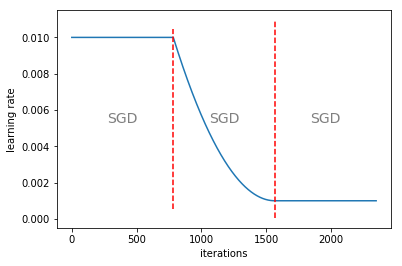

In [ ]:
learn.sched.plot_lr(show_moms=False)

In [ ]:
phases = [TrainingPhase(epochs=1, opt_fn=optim.SGD, lr = 1e-2), 
          TrainingPhase(epochs=1, opt_fn=optim.SGD, lr = (1e-2,1e-3), lr_decay=(DecayType.POLYNOMIAL, 0.5)),
          TrainingPhase(epochs=1, opt_fn=optim.SGD, lr = 1e-3)]

In [ ]:
learn.fit_opt_sched(phases)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                                                                              
    0      3.624198   4.435553   0.1493    
    1      3.594141   4.429299   0.152                                                                                 
    2      3.616898   4.439738   0.1514                                                                                


[array([4.43974]), 0.1514]

And here is an example where p = 0.5. In general, the greater p is, the more 'exponential' your curve will look (p=2 wasn't very different from exponential already). p=1 is simply linear (and close values will give something close to a line). Lower values of p (close to 0) will give a curve that stays up a bit longer before going down.


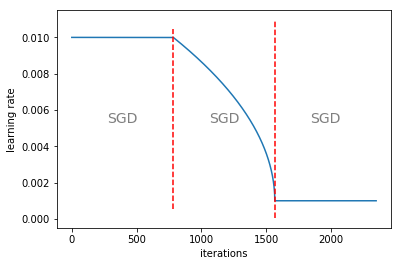

In [ ]:
learn.sched.plot_lr(show_moms=False)

If you don't specify an end value to the lr, it will be assumed the value you gave is the starting value and the end value is 0. This doesn't work for the EXPONENTIAL type of decay.

In [ ]:
phases = [TrainingPhase(epochs=1, opt_fn=optim.SGD, lr = 1e-2), 
          TrainingPhase(epochs=1, opt_fn=optim.SGD, lr = 1e-2, lr_decay=DecayType.COSINE),
          TrainingPhase(epochs=1, opt_fn=optim.SGD, lr = 1e-3)]

In [ ]:
learn.fit_opt_sched(phases)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                                                                              
    0      3.399492   4.549183   0.1378    
    1      3.388229   4.540058   0.1409                                                                                
    2      3.397341   4.548875   0.141                                                                                 


[array([4.54887]), 0.141]

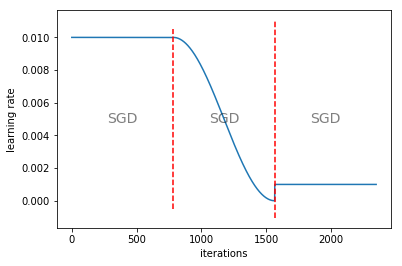

In [ ]:
learn.sched.plot_lr(show_moms=False)

All of those decays are implemented in the file sgdr.py in the function next_val of the class DecayScheduler. Adding your own is as simple as:
   - adding it in the DecayType class
   - implementing your own formula in the function next_val.

# SGDR

The traditional stochastic gradient with restart we used requires three arguments:
- the number of cycles
- the length of a cycle (cycle_len)
- the value by which we should multiply the cycle_len after each cycle (cycle_mult)

Also, note there is a warm-up at constant lr of 1/100th of the max value during 1/20th of the first cycle.

This can easily be implemented in a function (which you should now try to do by yourself) which creates a list of phases (number of cycles + 1 here). Remember you can have a float number for the epochs in a Training Phase.

In [ ]:
def phases_sgdr(lr, opt_fn, num_cycle,cycle_len,cycle_mult):
    phases = [TrainingPhase(epochs = cycle_len/ 20, opt_fn=opt_fn, lr=lr/100),
              TrainingPhase(epochs = cycle_len * 19/20, opt_fn=opt_fn, lr=lr, lr_decay=DecayType.COSINE)]
    for i in range(1,num_cycle):
        phases.append(TrainingPhase(epochs = cycle_len * (cycle_mult**i), opt_fn=opt_fn, lr=lr, lr_decay=DecayType.COSINE))
    return phases

In [ ]:
learn.fit_opt_sched(phases_sgdr(1e-2, optim.Adam, 2, 1, 2))

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                                                                              
    0      3.576923   4.471715   0.1359    
    1      3.773803   4.577302   0.1383                                                                                
    2      3.521146   4.507113   0.1402                                                                                


[array([4.50711]), 0.1402]

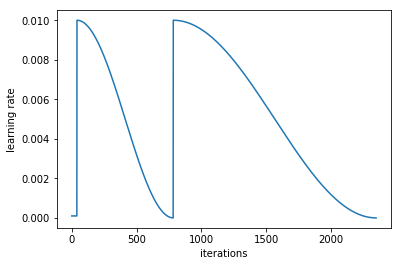

In [ ]:
learn.sched.plot_lr(show_text=False,show_moms=False)

Looks familiar?

# 1cycle

Leslie Smith's 1cycle policy states to pick a maximum learning rate with our traditional learning rate finder, choose a factor div by which to divide this learning rate, then do two phases of equal length going linearly from our minimal lr to our maximal lr, then back to the minimum.

In parallel, the momentum should begin high (like 0.95) and decrease to a minimum (like 0.85) as the lr grows, then returns to the maximum as the lr decreases.

To complete this cycle, allow a bit of time to let the learning rate decrease even more at the end (I chose to go from the minimum_lr to 1/100th of its value linearly since it was the thing that seemed to work the best in my experiments).

So let's create a function 1cycle that takes the arguments:
- cycle_len: the total length of the cycle (in epochs)
- lr: the maximum learning rate
- div: by how much do we want to divide the maximum lr
- pct: what percentage of epochs should be left at the end for the final annealing
- max_mom: the maximum momentum
- min_mom: the minimum momentum

The optim function should be SGD (with momentum).

In [ ]:
def phases_1cycle(cycle_len,lr,div,pct,max_mom,min_mom):
    tri_cyc = (1-pct/100) * cycle_len
    return [TrainingPhase(epochs=tri_cyc/2, opt_fn=optim.SGD, lr=(lr/div,lr), lr_decay=DecayType.LINEAR, 
                          momentum=(max_mom,min_mom), momentum_decay=DecayType.LINEAR),
           TrainingPhase(epochs=tri_cyc/2, opt_fn=optim.SGD, lr=(lr,lr/div), lr_decay=DecayType.LINEAR, 
                          momentum=(min_mom,max_mom), momentum_decay=DecayType.LINEAR),
           TrainingPhase(epochs=cycle_len-tri_cyc, opt_fn=optim.SGD, lr=(lr/div,lr/(100*div)), lr_decay=DecayType.LINEAR, 
                          momentum=max_mom)]

In [ ]:
learn.fit_opt_sched(phases_1cycle(3, 1e-2, 10, 10, 0.95, 0.85))

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                                                                              
    0      3.604487   4.53111    0.1389    
    1      3.739034   4.621771   0.1313                                                                                
    2      3.565503   4.512865   0.1425                                                                                


[array([4.51287]), 0.1425]

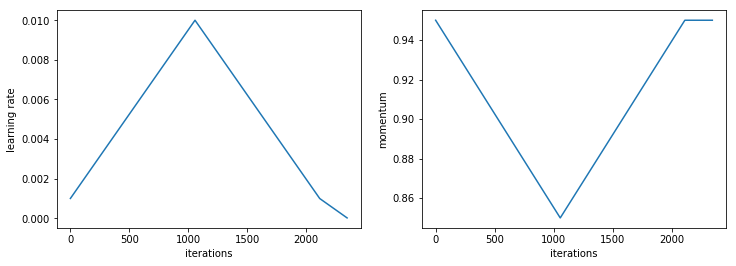

In [ ]:
learn.sched.plot_lr(show_text=False)

Now you can easily test different types of annealing at the end of the 1cycle.

# It supports discriminative learning rates.

When you unfreeze a pretrained model, you often use differential learning rates, and this works with this new API too. Just pass an array or a list of learning rates instead of a single value.

In [ ]:
learn = ConvLearner.pretrained(resnet34, data, metrics=[accuracy])

In [ ]:
learn.unfreeze()
lr = 1e-2
lrs = np.array([lr/100,lr/10,lr])

In [ ]:
phases = [TrainingPhase(epochs=1, opt_fn=optim.Adam, lr=(lrs/10,lrs), lr_decay=DecayType.LINEAR),
          TrainingPhase(epochs=2, opt_fn=optim.Adam, lr=lrs, lr_decay=DecayType.COSINE)]

In [ ]:
learn.fit_opt_sched(phases)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                                                                              
    0      1.762334   1.626667   0.3959    
    1      1.53574    1.601774   0.4827                                                                                
    2      1.496761   1.487644   0.5                                                                                   


[array([1.48764]), 0.5]

What is plotted in these cases is the highest learning rate.

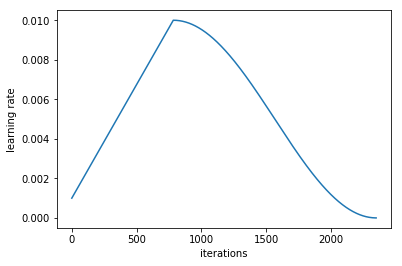

In [ ]:
learn.sched.plot_lr(show_text=False, show_moms=False)

# A customized LR Finder

This API can also be used to run a learning rate finder: just put a very low starting LR and a very large ending one, and choose exponential or linear decay. To stop when the loss go wild, we add the option stop_div= True. This can also be used in a regular fit if you want to stop the training in case the loss suddenly spikes.

As you can choose the number of epochs, this is particularly useful when you have a small dataset (you can run more epoxhs to have a clearer curve) or a very large one where a fraction of an epoch is plenty. In general 100-200 values are plenty to have a clear curve, so since we know we have 782 batches on cifar10, we'll run this customized LR Finder on 0.25 epochs.

In [ ]:
phases = [TrainingPhase(epochs=0.25, opt_fn=optim.SGD, lr=(1e-5,10), lr_decay=DecayType.EXPONENTIAL,momentum=0.9)]

In [ ]:
learn = ConvLearner.from_model_data(SimpleNet([32*32*3, 40,10]), data)

Be careful to save your model before fitting as the LR Finder will alter it.

In [ ]:
learn.save('tmp')
learn.fit_opt_sched(phases, stop_div=True)
learn.load('tmp')

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 18%|████████████▍                                                          | 137/782 [00:03<00:14, 45.64it/s, loss=17]


Then we can draw the curve with the usual command:

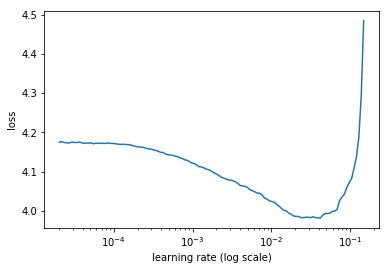

In [ ]:
learn.sched.plot()

If you choose a linear decay, the curve will be plotted without using a log scale for the learning rates. Be careful than we you use a linear scale for the lrs, you get very fast to the high ones so you can't put as wide a range.

In [ ]:
phases = [TrainingPhase(epochs=0.25, opt_fn=optim.SGD, lr=(0.001,0.1), lr_decay=DecayType.LINEAR,momentum=0.9)]
learn.save('tmp')
learn.fit_opt_sched(phases, stop_div=True)
learn.load('tmp')

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 19%|█████████████                                                        | 148/782 [00:02<00:12, 51.84it/s, loss=18.1]


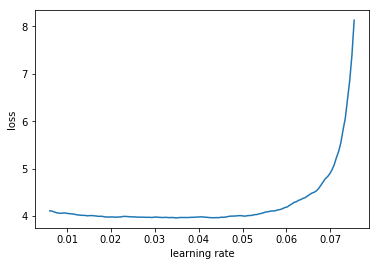

In [ ]:
learn.sched.plot()

You can always force the scale to be linear (or log scale) by using the optional argument linear in the plot function.

In [ ]:
phases = [TrainingPhase(epochs=0.25, opt_fn=optim.SGD, lr=(1e-5,10), lr_decay=DecayType.EXPONENTIAL,momentum=0.9)]
learn.save('tmp')
learn.fit_opt_sched(phases, stop_div=True)
learn.load('tmp')

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 18%|████████████▋                                                        | 144/782 [00:02<00:11, 55.21it/s, loss=27.2]


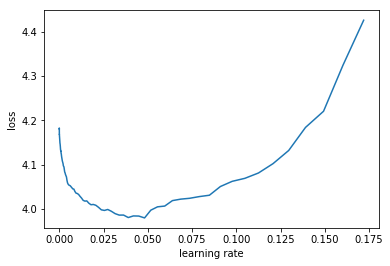

In [ ]:
learn.sched.plot(linear=True)

# But there's more!

The first thing that's possible with these blocks and didn't try yet is that you can change the optimizer at each phase. For instance, we can do a 1cycle with SGD and cyclical momentum but then anneal with Adam.

In [ ]:
phases = [TrainingPhase(epochs=1, opt_fn=optim.SGD, lr=(1e-3,1e-2), lr_decay=DecayType.LINEAR, 
                          momentum=(0.95,0.85), momentum_decay=DecayType.LINEAR),
           TrainingPhase(epochs=1, opt_fn=optim.SGD, lr=(1e-2,1e-3), lr_decay=DecayType.LINEAR, 
                          momentum=(0.85,0.95), momentum_decay=DecayType.LINEAR),
           TrainingPhase(epochs=1, opt_fn=optim.Adam, lr=1e-3, lr_decay=DecayType.COSINE, momentum=0.9)]

In [ ]:
learn.fit_opt_sched(phases)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                                                                              
    0      3.59037    4.5196     0.14      
    1      3.607808   4.601357   0.133                                                                                 
    2      3.543177   4.520047   0.1417                                                                                


[array([4.52005]), 0.1417]

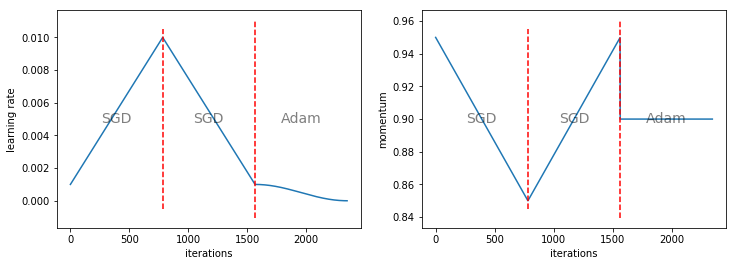

In [ ]:
learn.sched.plot_lr()

Lastly, you can even change your data during the training. This is only applicable for a full CNN that can works with any size, but you could decide to train it for a bit with a smaller size before increasing it. 

In [ ]:
def ConvBN(n_in, n_out, stride):
    return nn.Sequential(nn.Conv2d(n_in,n_out,3,stride=stride,padding=1), nn.BatchNorm2d(n_out))

In [ ]:
def ShallowConvNet():
    listlayers = [ConvBN(3,64,20), nn.ReLU(inplace=True), ConvBN(64,128,2), nn.ReLU(inplace=True),
                  nn.AdaptiveAvgPool2d(1), Flatten(), nn.Linear(128,10), nn.LogSoftmax(dim=0)]
    return nn.Sequential(*listlayers)

Let's grab the data for two different sizes.

In [ ]:
data1 = get_data(28,batch_size)
data2 = get_data(32,batch_size)

And create a learner object.

In [ ]:
learn = ConvLearner.from_model_data(ShallowConvNet(), data1)

And let's say we want to phases of cos anneal with Adam, but want to train on the size 28 for the first, then on the size 32.

In [ ]:
phases = [TrainingPhase(epochs=1, opt_fn=optim.Adam, lr=1e-2, lr_decay=DecayType.COSINE),
          TrainingPhase(epochs=2, opt_fn=optim.Adam, lr=1e-2, lr_decay=DecayType.COSINE)]

It's as simple as passing a list of data in the arguments of fir_opt_sched. One thing to pay attention to, this list must have the same size as phases, so if the same data object should be used through multiple phases, repeat it as needed.

In [ ]:
learn.fit_opt_sched(phases, data_list=[data1,data2])

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                                                                              
    0      3.701185   4.411829   0.156     
    1      3.638553   4.40993    0.1406                                                                                
    2      3.605458   4.432413   0.1452                                                                                


[array([4.43241]), 0.1452]

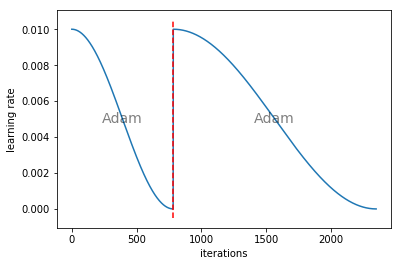

In [ ]:
learn.sched.plot_lr(show_moms=False)